# Models

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import xgboost as xgb
import json
import warnings

from recovery_factor.validate import get_scores, get_confusion_matrices

warnings.filterwarnings("ignore")

In [2]:
results_dir = Path("../results/")
params = dict()
for model in results_dir.glob("*.json"):
    # estimator = xgb.XGBClassifier()
    best_params = json.load(model.open())
    params[model.stem] = best_params

pd.DataFrame(params)[["TC-backup", "TA-backup", "CA-backup", "TCA-backup"]]

,TC-backup,TA-backup,CA-backup,TCA-backup
colsample_bytree,0.590914,0.911366,0.990764,0.897415
eta,0.212664,0.298511,0.296303,0.295458
max_depth,2.000000,4.000000,7.000000,7.000000
min_child_weight,6.000000,11.000000,8.000000,9.000000
subsample,0.944018,0.698121,0.740486,0.981343
alpha,NaN,NaN,NaN,NaN
lambda,NaN,NaN,NaN,NaN


In [3]:
scores = {}
for training_data in ("TC", "TA", "CA", "TCA"):
    scores[training_data] = get_scores(params[f"{training_data}-backup"], training_data)
scores = (
    pd.concat([pd.DataFrame(scores[db]).assign(Database=db) for db in scores])
    .rename_axis(index="Metric")
    .reset_index()
)

scores = scores.set_index(["Database", "Metric"]).apply(lambda x: np.round(x, 2))
scores.to_csv("model_scores.csv")
scores

Train  Test  Independent
Database Metric                                     
TC       accuracy            0.48  0.31         0.20
         within-1 accuracy   0.75  0.75         0.55
         precision           0.51  0.33         0.14
         recall              0.48  0.31         0.20
         f1                  0.45  0.29         0.13
         R2                  0.23  0.16        -0.49
TA       accuracy            0.59  0.34         0.24
         within-1 accuracy   0.81  0.73         0.68
         precision           0.59  0.33         0.20
         recall              0.59  0.34         0.24
         f1                  0.58  0.32         0.20
         R2                  0.44  0.22        -0.02
CA       accuracy            0.75  0.35         0.24
         within-1 accuracy   0.87  0.75         0.62
         precision           0.76  0.33         0.20
         recall              0.75  0.35         0.24
         f1                  0.75  0.33         0.20
         R2                  0.59  0.28        -0.31
TCA      accuracy            0.77  0.36          NaN
         within-1 accuracy   0.88  0.75          NaN
         precision           0.77  0.36          NaN
         recall              0.77  0.36          NaN
         f1                  0.76  0.35          NaN
         R2                  0.62  0.32          NaN

In [4]:
styled_scores = (
    scores.style.set_table_styles(
        [
            {"selector": "th", "props": [("font-weight", "bold"), ("text-align", "center")]},
            {"selector": "td", "props": [("text-align", "center")]},
        ]
    )
    .set_caption("Table 3. The performance metrics for each database")
    .format(na_rep="-", precision=2)
)

# Save to an HTML file that can be copied into Word
html = styled_scores.to_html()
with open("table3.html", "w") as f:
    f.write(html)

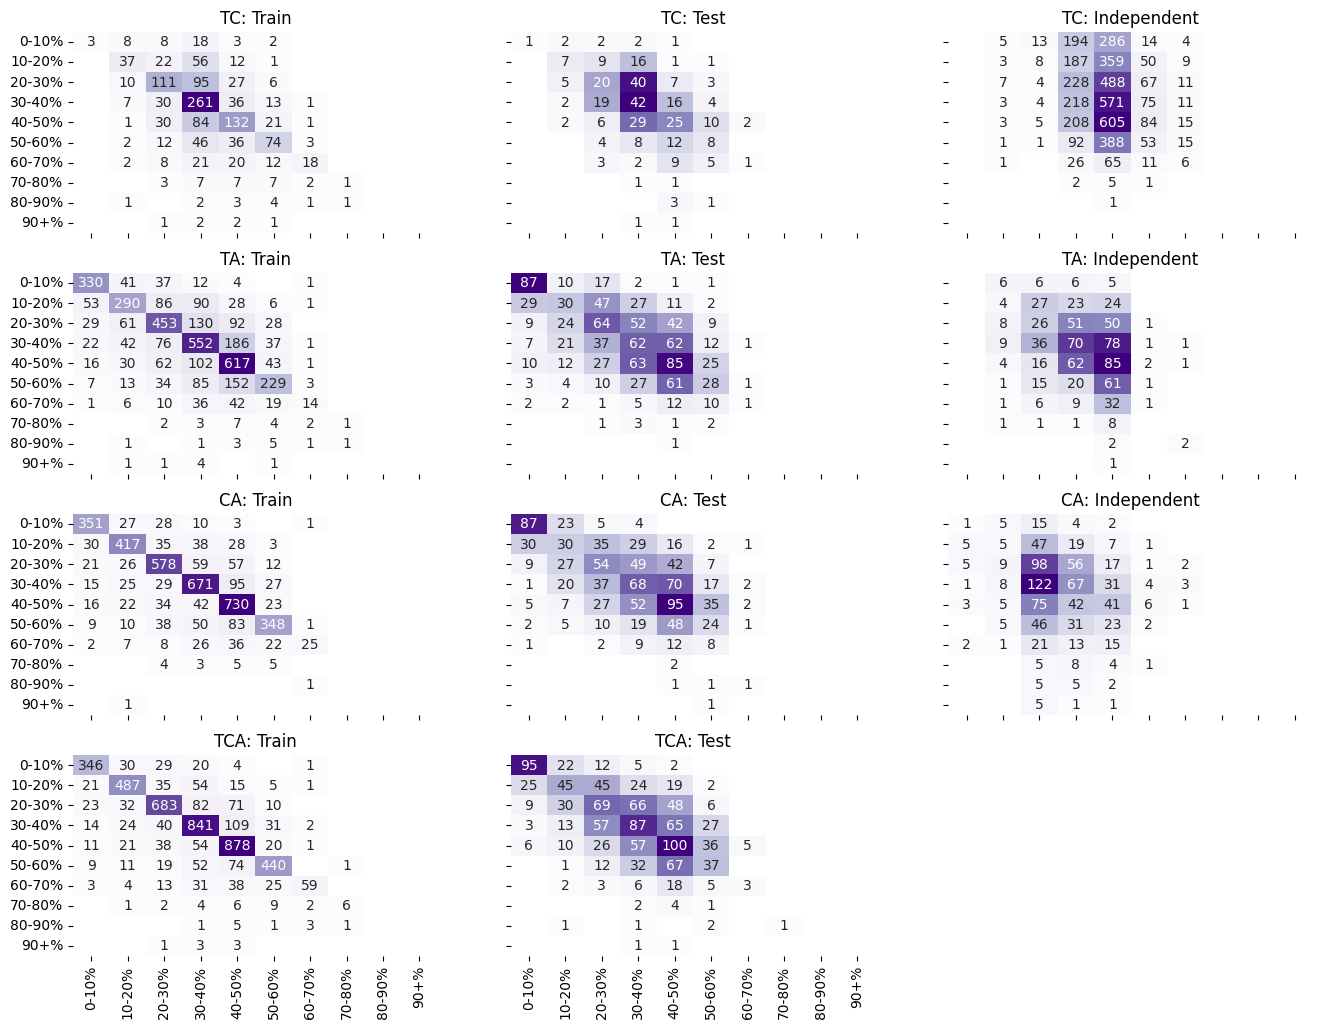

In [5]:
confusion_matrices = {}
for training_data in ("TC", "TA", "CA", "TCA"):
    confusion_matrices[training_data] = get_confusion_matrices(
        params[f"{training_data}-backup"], training_data
    )
confusion_matrices

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(4, 3, figsize=(16, 12), sharex=True, sharey=True)

models = ["TC", "TA", "CA", "TCA"]
mode = ["Train", "Test"]
index_labels = [
    "0-10%",
    "10-20%",
    "20-30%",
    "30-40%",
    "40-50%",
    "50-60%",
    "60-70%",
    "70-80%",
    "80-90%",
    "90+%",
]
for ax, model in zip(axes[:, 0], models):
    ax.set(title=f"{model}: Train")
    cm = pd.DataFrame(confusion_matrices[model]["Train"], index=index_labels, columns=index_labels)
    sns.heatmap(cm[cm > 0], cmap="Purples", annot=True, fmt="g", ax=ax, cbar=False)
for ax, model in zip(axes[:, 1], models):
    ax.set(title=f"{model}: Test")
    cm = confusion_matrices[model]["Test"]
    cm = pd.DataFrame(cm, index=index_labels[: len(cm)], columns=index_labels[: len(cm)])
    sns.heatmap(cm[cm > 0], cmap="Purples", annot=True, fmt="g", ax=ax, cbar=False)
for ax, model in zip(axes[:3, 2], models[:-1]):
    ax.set(title=f"{model}: Independent")
    cm = confusion_matrices[model]["Independent"]
    cm = pd.DataFrame(cm, index=index_labels[: len(cm)], columns=index_labels[: len(cm)])
    sns.heatmap(cm[cm > 0], cmap="Purples", annot=True, fmt="g", ax=ax, cbar=False)
axes[-1, -1].set_visible(False)
fig.savefig("heatmaps-fig3.png", dpi=200, bbox_inches="tight")